In [287]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import scipy.spatial.distance as ssd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [267]:
def get_vector(frame, components, col):

    #number of unique values and dictionary of unique values
    #number = classification.nunique(axis=0)
    components.update(frame[col].value_counts().to_dict())
    #vector = np.fromiter(components.values(), dtype = int)
    vector = pd.DataFrame([components.values()])
    return(vector)

In [219]:
#FASTA metadata upload, faster version of the one in the masterthesis
exclude = [i for i, line in enumerate(open('A.fasta')) if not line.startswith('>')]
metadata = pd.read_csv('A.fasta', skiprows = exclude, sep = '|', na_filter = False, header = None)
metadata.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation']

In [220]:
#upload cluster dataframe, join to metadata minus equivalent segment column
cluster = pd.read_csv('cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
intersection = set(metadata.columns) & set(cluster.columns)
classification = cluster.join(metadata.set_index('accession').drop(columns=list(intersection), axis=1))

In [221]:
#Date Column Cleanup and components
classification[['month', 'day', 'year']] = classification['date'].apply(lambda x : x if len(re.findall('/', x)) == 2 else (x.split('/')[0] + '/NA/' + x.split('/')[1] if len(re.findall('/', x)) == 1 else 'NA/NA/' + x)).str.split('/', expand=True)
names = pd.Series({c: classification[c].unique() for c in classification})
components = dict.fromkeys(names['year'], 0)

In [278]:
#vector creation and reduction
vectors = classification.groupby(by=['segment', 'cluster']).apply(lambda x: get_vector(x, components, 'year'))
vectors_l1 = normalize(vectors.loc[4].to_numpy(), norm='l1')
matrix = ssd.cdist(vectors_l1, vectors_l1)

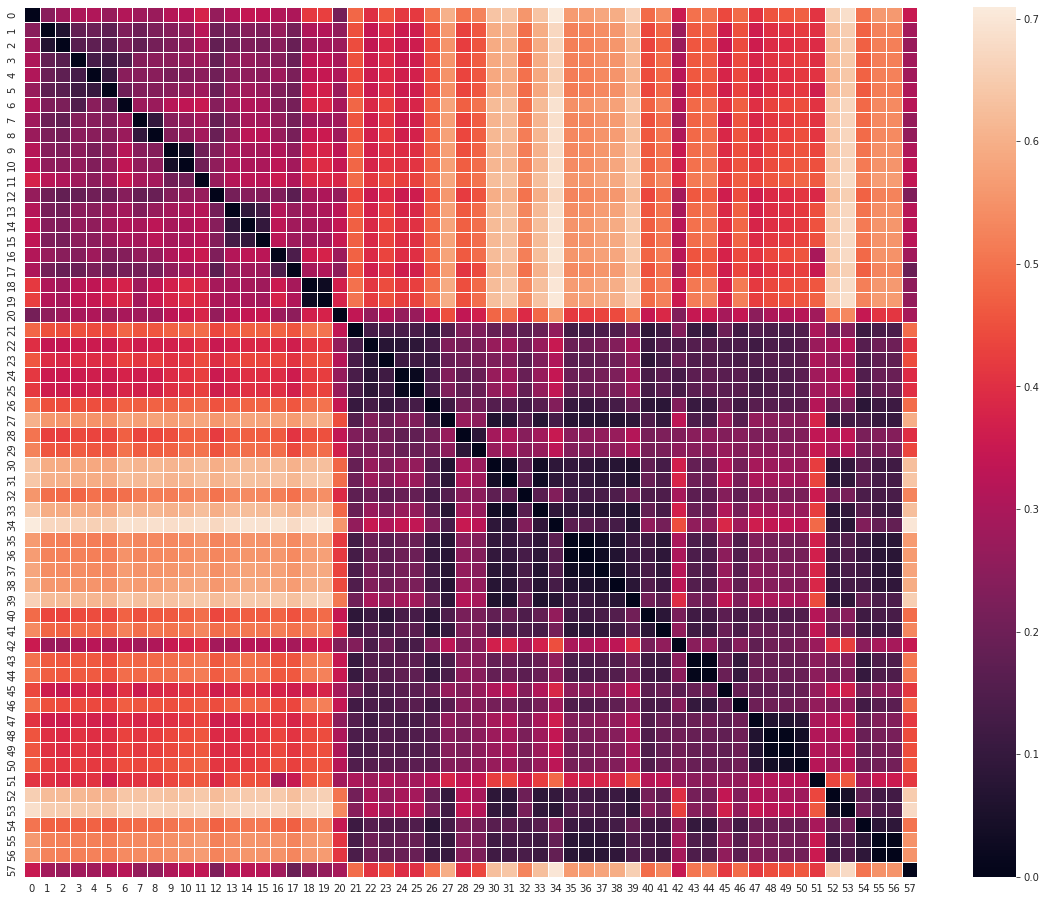

In [290]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(20,16))
    sns.heatmap(matrix, linewidths=.5, ax=ax)